_ATU Donegal - MSc in Data Science: Machine Learning_
**<h1>KNN ($K$-Nearest Neighbors)</h1>**

KNN is an algorithm built on a simple concept: define a distance metric between the items in your dataset, and find the $k$ closest items. You can then use those items to predict some property of a test item, by having them vote on it.



As an example, we'll look at the MovieLens data. We'll try to guess the rating of a movie by looking at the 10 movies that are closest to it in terms of genres and popularity.

To start, we'll load up every rating in the data set into a Pandas DataFrame:

In [1]:
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('https://github.com/paulgreaney/data/raw/main/u.data', sep='\t', names=r_cols, usecols=range(3))
ratings.head()


,user_id,movie_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


Now, we'll group everything by movie ID, and compute the total number of ratings (each movie's popularity) and the average rating for every movie:

In [2]:
import numpy as np

movie_properties = ratings.groupby('movie_id').agg({'rating': [np.size, np.mean]})
movie_properties.head()

rating          
           size      mean
movie_id                 
1           452  3.878319
2           131  3.206107
3            90  3.033333
4           209  3.550239
5            86  3.302326

The raw number of ratings isn't very useful for computing distances between movies, so we'll create a new DataFrame that contains the normalised number of ratings. So, a value of 0 means nobody rated it, and a value of 1 will mean it's the most popular movie there is.

In [3]:
movie_num_ratings = pd.DataFrame(movie_properties['rating']['size'])
movie_normalized_num_ratings = movie_num_ratings.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
movie_normalized_num_ratings.head()

,size
movie_id,
1,0.773585
2,0.222985
3,0.152659
4,0.356775
5,0.145798


In [4]:
movie_properties.columns

MultiIndex([('rating', 'size'),
            ('rating', 'mean')],
           )

In [5]:
pd.DataFrame(movie_properties['rating']['mean'])

,mean
movie_id,
1,3.878319
2,3.206107
3,3.033333
4,3.550239
5,3.302326
...,...
1678,1.000000
1679,3.000000
1680,2.000000


Now, let's get the genre information from the u.item file. The way this works is there are 19 fields, each corresponding to a specific genre - a value of '0' means it is not in that genre, and '1' means it is in that genre. A movie may have more than one genre associated with it.

While we're at it, we'll put together everything into one big Python dictionary called movieDict. Each entry will contain the movie name, list of genre values, the normalized popularity score, and the average rating for each movie:

In [6]:
!wget https://github.com/paulgreaney/data/raw/main/u.item
movie_dict = {}
with open(r'u.item', encoding = "ISO-8859-1") as f:
    temp = ''
    for line in f:
        line
        fields = line.rstrip('\n').split('|')
        movie_id = int(fields[0])
        name = fields[1]
        genres = fields[5:25]
        genres = map(int, genres)
        movie_dict[movie_id] = (name, np.array(list(genres)) , movie_properties.loc[movie_id].rating.get('mean'))


--2024-02-09 14:58:49--  https://github.com/paulgreaney/data/raw/main/u.item
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/paulgreaney/data/main/u.item [following]
--2024-02-09 14:58:49--  https://raw.githubusercontent.com/paulgreaney/data/main/u.item
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236344 (231K) [text/plain]
Saving to: ‘u.item.2’

u.item.2            100%[===================>] 230.80K  --.-KB/s    in 0.01s   

2024-02-09 14:58:49 (15.8 MB/s) - ‘u.item.2’ saved [236344/236344]



In [7]:
# with open(r'u.item', encoding = "ISO-8859-1") as f:
#     temp = ''
#     for line in f:
#         line
#         fields = line.rstrip('\n').split('|')
#         print(f'line = {line} \n fields = {fields}')
#         movie_id = int(fields[0])
#         print(f'Movie id = {movie_id}')
#         name = fields[1]

#         genres = fields[5:25]
#         genres = map(int, genres)

#         print(f'genres = {np.array(list(genres))}')

#         break
#     #     movie_dict[movie_id] = (name, np.array(list(genres)) , movie_properties.loc[movie_id].rating.get('mean'))


For example, here's the record we end up with for movie ID 1, "Toy Story":

In [8]:
print(movie_dict[1])


('Toy Story (1995)', array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 3.8783185840707963)


Now let's define a function that computes the "distance" between two movies based on how similar their genres are, and how similar their popularity is. Just to make sure it works, we'll compute the distance between movie ID's 2 and 4:

In [9]:
from scipy import spatial

def compute_distance(a, b):
    genres_a = a[1]
    genres_b = b[1]
    # print(f"genres_a = {genres_a} \n genres_b = {genres_b}")
    genre_distance = spatial.distance.cosine(genres_a, genres_b)
    popularity_a = a[2]
    popularity_b = b[2]
    # print(f"popularity_a = {popularity_a} \n popularity_b = {popularity_b}")

    popularity_distance = abs(popularity_a - popularity_b)
    # print(f'popularity_distance = {popularity_distance}')
    return genre_distance + popularity_distance

compute_distance(movie_dict[2], movie_dict[4])



1.01079903088742

Remember the higher the distance, the less similar the movies are. Let's check what movies 2 and 4 actually are - and confirm they're not really all that similar:

In [10]:
print(movie_dict[2])
print(movie_dict[4])


('GoldenEye (1995)', array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 3.2061068702290076)
('Get Shorty (1995)', array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 3.550239234449761)


Now, we just need a little code to compute the distance between some given test movie (Toy Story, in this example) and all of the movies in our data set. When the sort those by distance, and print out the $k$ nearest neighbours:

In [11]:
import operator

def get_neighbours(movie_id, K):
    distances = []
    for movie in movie_dict:
        if (movie != movie_id):
            dist = compute_distance(movie_dict[movie_id], movie_dict[movie])
            distances.append((movie, dist))
    distances.sort(key=operator.itemgetter(1))
    neighbours = []
    for x in range(K):
        neighbours.append(distances[x][0])
    return neighbours

K = 10
avg_rating = 0
neighbours = get_neighbours(1, K)
for neighbour in neighbours:
    avg_rating += movie_dict[neighbour][2]
    print(movie_dict[neighbour][0] + " " + str(movie_dict[neighbour][2]))

avg_rating /= K

Aladdin (1992) 3.8127853881278537
Winnie the Pooh and the Blustery Day (1968) 3.8
Pinocchio (1940) 3.6732673267326734
Grand Day Out, A (1992) 4.106060606060606
Beauty and the Beast (1991) 3.792079207920792
Raising Arizona (1987) 3.875
Ruling Class, The (1972) 3.875
Lion King, The (1994) 3.7818181818181817
Fantasia (1940) 3.7701149425287355
Being There (1979) 3.9051724137931036


While we were at it, we computed the average rating of the 10 nearest neighbors to Toy Story:

In [12]:
avg_rating

3.8391298066981947

How does this compare to Toy Story's actual average rating?

In [13]:
movie_dict[1]

('Toy Story (1995)',
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 3.8783185840707963)

Not too bad!


#### Exercises

##### 1.Our choice of $k=10$ was arbitrary - what effect do different $k$ values have on the results?



##### 2.Our distance metric was also somewhat arbitrary - we just took the cosine distance between the genres and added it to the difference between the normalized popularity scores. Can you improve on that?

In [14]:
for i in range(2,40):
  K = i
  avg_rating = 0
  neighbours = get_neighbours(1, K)
  for neighbour in neighbours:
      avg_rating += movie_dict[neighbour][2]
      # print(movie_dict[neighbour][0] + " " + str(movie_dict[neighbour][2]))

  avg_rating /= K
  print('_________________________')
  print(f'k = {K}\navg_rating ==== {avg_rating}\nactual rating ===== {movie_dict[1][2]}')

  ## The Acuracu is more after 27 value of k

_________________________
k = 2
avg_rating ==== 3.806392694063927
actual rating ===== 3.8783185840707963
_________________________
k = 3
avg_rating ==== 3.762017571620176
actual rating ===== 3.8783185840707963
_________________________
k = 4
avg_rating ==== 3.8480283302302833
actual rating ===== 3.8783185840707963
_________________________
k = 5
avg_rating ==== 3.836838505768385
actual rating ===== 3.8783185840707963
_________________________
k = 6
avg_rating ==== 3.8431987548069877
actual rating ===== 3.8783185840707963
_________________________
k = 7
avg_rating ==== 3.847741789834561
actual rating ===== 3.8783185840707963
_________________________
k = 8
avg_rating ==== 3.8395013388325134
actual rating ===== 3.8783185840707963
_________________________
k = 9
avg_rating ==== 3.831791739243205
actual rating ===== 3.8783185840707963
_________________________
k = 10
avg_rating ==== 3.8391298066981947
actual rating ===== 3.8783185840707963
_________________________
k = 11
avg_rating ==== 3

In [15]:
avg_rating


3.850311702240059

In [16]:
movie_dict[1]

('Toy Story (1995)',
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 3.8783185840707963)

## KNN for Handwritten Digit Recognition

We can apply the KNN algorithm to images, on the basis that images with some degree of similarity should be 'close' to each other in the feature space.

Let's do this with the MNIST set of handwritten digits. This is a standard machine learning dataset which is often used to learn about model development and performance.

In [37]:
from sklearn.datasets import fetch_openml, load_digits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

mnist = fetch_openml("mnist_784")


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [38]:
# print(mnist)

In [39]:
mnist.keys()
mnist.target = mnist.target.astype(np.int8)
#Determining independent and dependent variable and finding the shape
x = np.array(mnist.data)
y = np.array(mnist.target)
x.shape, y.shape


((70000, 784), (70000,))

In [40]:
mnist.keys(), mnist.target

(dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url']),
 0        5
 1        0
 2        4
 3        1
 4        9
         ..
 69995    2
 69996    3
 69997    4
 69998    5
 69999    6
 Name: class, Length: 70000, dtype: int8)

In [41]:
# shuffling the values of x and y
randomised_order = np.random.permutation(x.shape[0])
x = x[randomised_order]
y = y[randomised_order]

Let's look at an example from the dataset:

In [42]:
# y.shape
x.shape

(70000, 784)

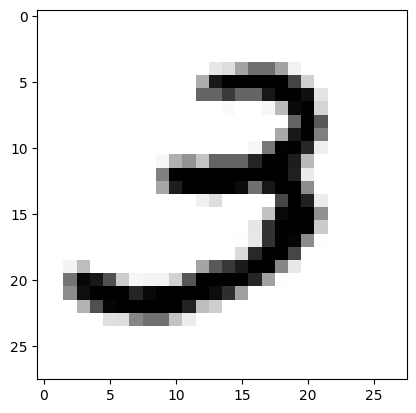

In [43]:
some_digit = x[69996]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary)

We've already shuffled the dataset, so we can set up our train and test dataset directly from the shuffled set:

In [44]:
x_train = x[:8000]
y_train = y[:8000]
x_test = x[8000:10000]
y_test = y[8000:10000]

train = np.insert(x_train, 784, y_train, axis=1)

Now let's use the SKLearn nearest neighbours module to create a model and run some inference on our test set:

In [45]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=4)
model.fit(x_train, y_train)

test_image = x[69996]
model.predict(np.reshape(test_image, (1,784)))

array([3], dtype=int8)

Check that this corresponds to the image:

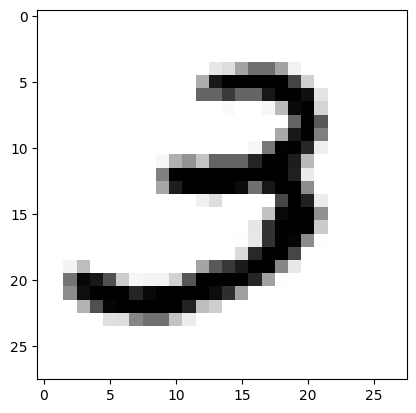

In [46]:
plt.imshow(test_image.reshape(28, 28), cmap=matplotlib.cm.binary)

#### Exercises

##### 3.Extend the code above to determine the performance of the model on the test set we created. Try creating a confusion matrix to further illustrate the performance on each class (check out `sklearn.metrics.confusion_matrix`).*

In [47]:
from sklearn.metrics import confusion_matrix,accuracy_score

model = KNeighborsClassifier(n_neighbors=4)
model.fit(x_train, y_train)

test_image = x_test[20]
# y_pred = model.predict(np.reshape(test_image, (1,784)))
y_pred = model.predict(x_test)


print(accuracy_score(y_test, y_pred))

0.938


In [48]:
confusion_matrix(y_test, y_pred)

array([[198,   1,   0,   0,   0,   1,   3,   0,   0,   0],
       [  0, 209,   1,   0,   0,   0,   0,   0,   0,   0],
       [  3,   5, 173,   1,   0,   0,   1,   4,   1,   0],
       [  1,   1,   6, 171,   0,   0,   0,   1,   2,   0],
       [  0,   5,   0,   0, 192,   0,   0,   0,   0,   7],
       [  0,   5,   0,  11,   0, 155,   0,   0,   0,   1],
       [  6,   0,   1,   0,   0,   0, 187,   0,   0,   0],
       [  1,   5,   0,   0,   2,   0,   0, 224,   0,   4],
       [  0,   4,   2,   5,   2,   4,   1,   1, 165,   4],
       [  1,   0,   0,   5,   6,   1,   0,   8,   0, 202]])

##### 4.Use a for loop to determine the model (value of $k$) which has the best performance.*

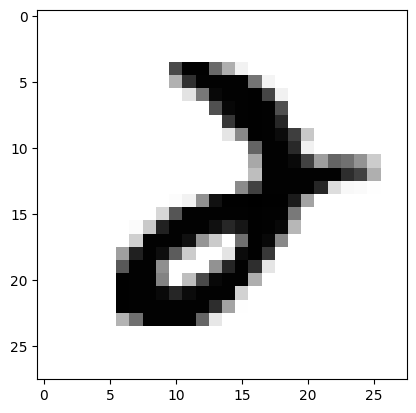

In [28]:
p = x_test[3]
plt.imshow(p.reshape(28, 28), cmap=matplotlib.cm.binary)


In [29]:
for i in range(1,40):
  model = KNeighborsClassifier(n_neighbors=i)
  model.fit(x_train, y_train)

  test_image = x_test[3]
  pred = model.predict(np.reshape(test_image, (1,784)))
  y_pred = model.predict(x_test)
  print(f"k = {i}")
  # print(f"prediction = {pred}")
  print(f"Accuracy score = {accuracy_score(y_test, y_pred)}")


  print("________________________________________________________")

k = 1
Accuracy score = 0.9505
________________________________________________________
k = 2
Accuracy score = 0.9355
________________________________________________________
k = 3
Accuracy score = 0.948
________________________________________________________
k = 4
Accuracy score = 0.946
________________________________________________________
k = 5
Accuracy score = 0.9465
________________________________________________________
k = 6
Accuracy score = 0.9435
________________________________________________________
k = 7
Accuracy score = 0.9445
________________________________________________________
k = 8
Accuracy score = 0.9455
________________________________________________________
k = 9
Accuracy score = 0.9435
________________________________________________________
k = 10
Accuracy score = 0.942
________________________________________________________
k = 11
Accuracy score = 0.939
________________________________________________________
k = 12
Accuracy score = 0.9385
______________

##### 5.We saw in the lecture how to implement $k$-NN from scratch (with uniform weighting, i.e. not based on distance). Adapt this code to create a distance-weighted $k$-NN model for the social network ads dataset using the inverse squared distance discussed in the lecture. Compare the accuracy of the weighted and unweighted approaches.*

In [53]:
import pandas as pd
import numpy as np
!wget https://github.com/paulgreaney/data/raw/main/social_network_ads.csv
social_data = pd.read_csv('social_network_ads.csv')
social_data.head()

--2024-02-09 15:14:52--  https://github.com/paulgreaney/data/raw/main/social_network_ads.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/paulgreaney/data/main/social_network_ads.csv [following]
--2024-02-09 15:14:52--  https://raw.githubusercontent.com/paulgreaney/data/main/social_network_ads.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10926 (11K) [text/plain]
Saving to: ‘social_network_ads.csv.3’

social_network_ads. 100%[===================>]  10.67K  --.-KB/s    in 0s      

2024-02-09 15:14:53 (80.5 MB/s) - ‘social_network_ads.csv.3’ saved [10926/10926]



,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [54]:
#Data cleaning and train/test split
social_data['Gender'].replace('Male', 0, inplace=True)
social_data['Gender'].replace('Female', 1, inplace=True)

X = np.array(social_data[['Gender', 'Age', 'EstimatedSalary']])
y = np.array(social_data['Purchased'])

randomised_order = np.random.permutation(X.shape[0])
X = X[randomised_order]
y = y[randomised_order]

print(X.shape, y.shape)
X_train, X_test = X[:360], X[360:]
y_train, y_test = y[:360], y[360:]

(400, 3) (400,)


In [139]:
import numpy as np
from scipy.stats import mode
from sklearn.utils.extmath import weighted_mode

def knn_classify(data, labels, p, k):
    distances=[]
    for sample, label in zip(data, labels):
        dist = np.sqrt(np.sum((sample-p)**2))
        # print(f"data={data} \n label={label} \n dist = {dist}")
        distances.append([dist, label])
    distances = np.array(distances).reshape(len(data), 2)
    distances = distances[distances[:, 0].argsort()][:k]
    print(f"distance_len = {len(distances)}")
    return int(mode(distances[:,1])[0])


# Distance wighted KNN

def distance_weighted_knn_classify(data, labels, p, k):
    distances=[]
    weights=[]
    for sample, label in zip(data, labels):

        dist = np.sqrt(np.sum((sample-p)**2))

        # What should we do if the square is 0

        if dist>0:
          w = 1/dist
        else:
          w = 0.001
        # dist = 1/sqr_val

        distances.append([dist, label])
        weights.append(w)


    distances = np.array(distances).reshape(len(data), 2)
    distances = distances[distances[:, 0].argsort()][:k]
    # print(distances)
    # print(len(distances[:,1]),len(weights))
    return int(weighted_mode(distances[:,1],weights))



# def distance_weighted_knn_classify(data, labels, p, k):
#     distances = []
#     for sample, label in zip(data, labels):
#         dist = np.sqrt(np.sum((sample - p) ** 2))
#         distances.append([dist, label])

#     distances = np.array(distances).reshape(len(data), 2)
#     distances = distances[distances[:, 0].argsort()][:k]

#     # Calculate inverse squared distances
#     inv_squared_distances = 1 / (distances[:, 0] ** 2)

#     # # Weighted voting
#     # weighted_votes = Counter(distances[:, 1] * inv_squared_distances)

#     # # Predict the class label with the highest weighted vote
#     # prediction = int(weighted_votes.most_common(1)[0][0])

#     # return prediction
#     print(inv_squared_distances)
#     return int(mode(inv_squared_distances[:,1])[0])


In [140]:
# test performance
predictions = []
for i in range(len(X_test)):
    pred = knn_classify(X_train, y_train, X_test[i], k=10)
    predictions.append(pred)

np.sum(predictions==y_test)/len(y_test)

distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10
distance_len = 10


0.8

In [148]:

def distance_weighted_knn_classify(data, labels, p, k):
    distances=[]
    weights=[]
    for sample, label in zip(data, labels):

        dist = np.sqrt(np.sum((sample-p)**2))

        # What should we do if the square is 0

        if dist>0:
          w = 1/dist
        else:
          w = 0.001

        distances.append([dist, label])
        weights.append(w)


    distances = np.array(distances).reshape(len(data), 2)
    distances = distances[distances[:, 0].argsort()][:k]
    # print(weights)
    # weights = weights[np.array(weights).argsort()][:k].reverse()


    # weights = weights[weights[:,]]
    return weighted_mode(distances[:,1],(1/(distances[:,0]+0.001)))[0]



In [157]:
# test performance for unweighted approach
predictions = []
for i in range(len(X_test)):
    pred = distance_weighted_knn_classify(X_train, y_train, X_test[i], k=10)
    predictions.append(pred[0])

# predictions = list(predictions)
# print(predictions.shape)
np.sum(predictions==y_test)/len(y_test)

0.875

In [153]:
print(predictions==y_test)

[[ True  True False ... False  True False]
 [ True  True False ... False  True False]
 [False False  True ...  True False  True]
 ...
 [False False  True ...  True False  True]
 [False False  True ...  True False  True]
 [False False  True ...  True False  True]]


In [150]:
print(predictions)
print(y_test)

[array([0.]), array([0.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.]), array([1.]), array([0.]), array([1.]), array([0.]), array([0.]), array([0.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([1.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.])]
[0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 1 0 1]


### Assessment
To get the marks for this lab, you should show your solution to exercises 3, 4 and 5 to the lecturer.